In [131]:
import sys
sys.path.append("../PythonScripts")
from preprocessing_utils import preprocess
from utils import save_to_synapse
from sklearn.decomposition import PCA
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import warnings
import os

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

In [132]:
syn = sc.login()

Welcome, aryton tediarjo!



In [316]:
entityV1 = syn.get("syn21046180")
dataV1   = pd.read_csv(entityV1["path"], index_col = 0)
entityV2 = syn.get("syn21046181")
dataV2   = pd.read_csv(entityV2["path"], index_col = 0)
entityPassive = syn.get("syn21046184")
dataPassive   = pd.read_csv(entityPassive["path"], index_col = 0)

In [317]:
dataV1 = preprocess(dataV1, True)
dataV1["version"] = "V1"
dataV2 = preprocess(dataV2, True)
dataV2["version"] = "V2"

In [318]:
data = pd.concat([dataV1, dataV2]).reset_index(drop = True)
# data = data[(data["PD"] == 1) & (data["gender"] == "male")]

In [319]:
def annot_phone(params):
    if ("iPhone 6+" in params) or ("iPhone 6 Plus" in params):
        return "6+"
    elif ("Unknown iPhone" in params) or ("iPhone 9" in params):
        return "others"
    else:
        return params

In [320]:
data["phone_number"]  = data["phoneInfo"].apply(lambda x: annot_phone(x.split(";")[0]))

In [321]:
data.columns

Index(['MAX_AA.freeze_occurences_per_sec', 'MAX_AA.frequency_of_peaks_log',
       'MAX_AA.gait_step_regularity', 'MAX_AA.gait_symmetry',
       'MAX_AA.max_freeze_index', 'MAX_AA.speed_of_gait',
       'MAX_FC.no_of_steps_per_sec', 'MAX_FC.speed_of_gait',
       'MAX_x.freeze_occurences_per_sec', 'MAX_x.frequency_of_peaks_log',
       'MAX_x.gait_step_regularity', 'MAX_x.gait_symmetry',
       'MAX_x.max_freeze_index', 'MAX_x.speed_of_gait',
       'MAX_y.freeze_occurences_per_sec', 'MAX_y.frequency_of_peaks_log',
       'MAX_y.gait_step_regularity', 'MAX_y.gait_symmetry',
       'MAX_y.max_freeze_index', 'MAX_y.speed_of_gait',
       'MAX_z.freeze_occurences_per_sec', 'MAX_z.frequency_of_peaks_log',
       'MAX_z.gait_step_regularity', 'MAX_z.gait_symmetry',
       'MAX_z.max_freeze_index', 'MAX_z.speed_of_gait', 'PD', 'age',
       'appVersion', 'createdOn', 'duration', 'education', 'gender',
       'phoneInfo', 'recordId', 'version', 'phone_number'],
      dtype='object')

# PCA

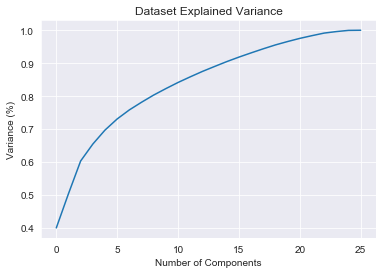

In [322]:
scaler = StandardScaler()
X = data[[feat for feat in data.columns if ("." in feat)]]
X_scaled = scaler.fit_transform(X)
#Plotting the Cumulative Summation of the Explained Variance
pca = PCA().fit(X_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.grid()
plt.show()

In [323]:
X_scaled = scaler.fit_transform(X)
y = data[["phone_number","appVersion", "version", "PD", "duration"]].reset_index(drop = True)
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_comp)
principal_df = pd.concat([principal_df, y], axis = 1)

# Isolated Feature healthCodes

In [349]:
male_PD_data = data[(data["gender"] == "male") & (data["PD"] == 1)].reset_index(drop = True)

In [350]:
X = male_PD_data[[feat for feat in male_PD_data.columns if ("." in feat)]]
y = male_PD_data[["version", "PD"]]
X_scaled = scaler.fit_transform(X)


#Plotting the Cumulative Summation of the Explained Variance
pca = PCA().fit(X_scaled)
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_comp)
principal_df = pd.concat([principal_df, y], axis = 1)

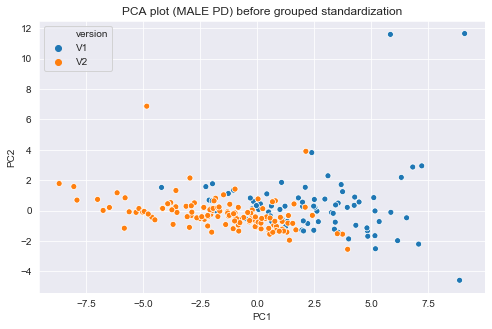

In [352]:
plt.figure(figsize=(8,5))
sns.scatterplot(principal_df[0], principal_df[1], 
                hue = principal_df["version"])
plt.title("PCA plot (MALE PD) before grouped standardization")
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.grid()
plt.show()

# Which feature values in V2 biased?

EVEEEERYTHINGGGG

In [345]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
standard_scaler = StandardScaler() 
# robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
feature_cols = [i for i in data.columns if ("x" in i) or ("y" in i) or ("z" in i) 
                or ("AA" in i)]


def plot_distribution_scaling(data):
    
    data_V1 = data[data["version"] == "V1"].reset_index(drop = True)
    data_V2 = data[data["version"] == "V2"].reset_index(drop = True)
    
    ## scaled to normal distribution ##
    normal_scaled_data_V1 = pd.DataFrame(data = standard_scaler.fit_transform(
                                                data_V1[feature_cols].dropna()),
                                         columns = feature_cols)
    normal_scaled_data_V1 = pd.concat([normal_scaled_data_V1, data_V1["version"]], axis = 1)
    
    normal_scaled_data_V2 = pd.DataFrame(data = standard_scaler.fit_transform(
                                                data_V2[feature_cols].dropna()),
                                         columns = feature_cols)
    normal_scaled_data_V2 = pd.concat([normal_scaled_data_V2, data_V2["version"]], axis = 1)
    
#     return normal_scaled_data_V2
#     ## scaled to robust scaler ##
#     robust_scaled_data = pd.DataFrame(data = robust_scaler.fit_transform(data[feature_cols].dropna()),
#                                       columns = feature_cols)
#     robust_scaled_data = pd.concat([robust_scaled_data, data["version"]], axis = 1)
#     robust_scaled_data_V1 = robust_scaled_data[robust_scaled_data["version"] == "V1"]
#     robust_scaled_data_V2 = robust_scaled_data[robust_scaled_data["version"] == "V2"]
    
    
    ## minmax scaled data ## 
    minmax_scaled_data_V1 = pd.DataFrame(data = minmax_scaler.fit_transform(
                                                data_V1[feature_cols].dropna()),
                                         columns = feature_cols)
    minmax_scaled_data_V1 = pd.concat([minmax_scaled_data_V1, data_V1["version"]], axis = 1)
    
    minmax_scaled_data_V2 = pd.DataFrame(data = minmax_scaler.fit_transform(
                                                data_V2[feature_cols].dropna()),
                                         columns = feature_cols)
    minmax_scaled_data_V2 = pd.concat([minmax_scaled_data_V2, data_V2["version"]], axis = 1)
    
    
    for i in feature_cols:
        
        fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,5))
        
        sns.distplot(data_V1[i], ax = axes[0], hist = "False", label = "V1")
        sns.distplot(data_V2[i], ax = axes[0], hist = "False", label = "V2")
        sns.distplot(normal_scaled_data_V1[i], ax = axes[1], hist = "False", label = "V1")
        sns.distplot(normal_scaled_data_V2[i], ax = axes[1], hist = "False", label = "V2")
        sns.distplot(minmax_scaled_data_V1[i], ax = axes[2], hist = "False", label = "V1")
        sns.distplot(minmax_scaled_data_V2[i], ax = axes[2], hist = "False", label = "V2")
        axes[0].grid()
        axes[0].set_title("pre-transformation distribution")
        axes[0].legend()
        axes[1].grid()
        axes[1].set_title("standardized distribution")
        axes[1].legend()
        axes[2].grid()
        axes[2].set_title("minmax distribution")
        axes[2].legend()
        plt.show()

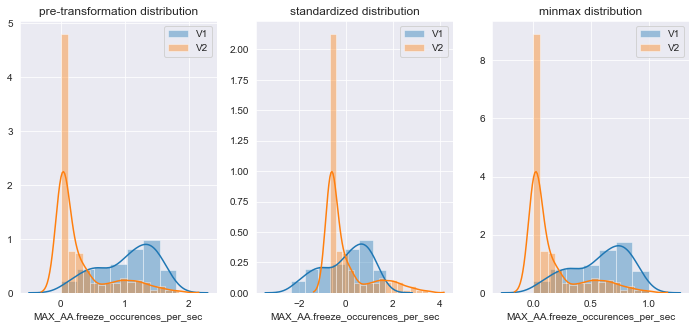

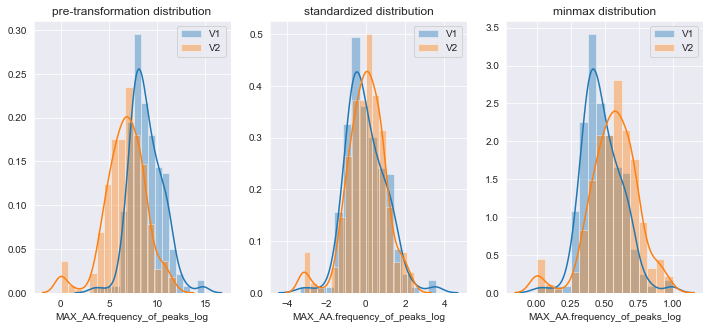

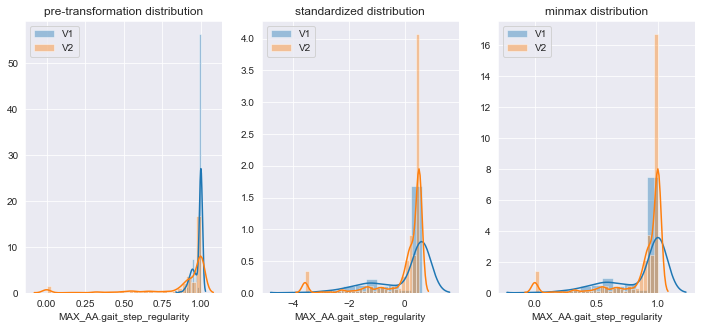

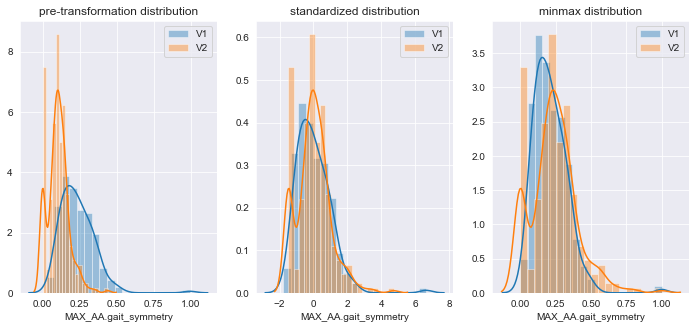

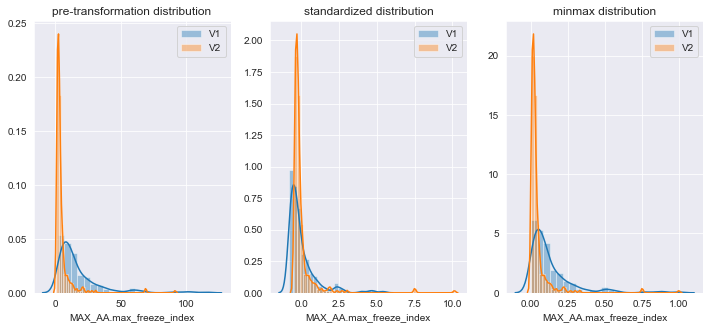

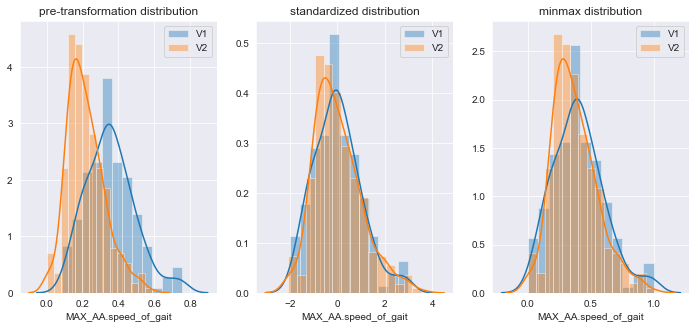

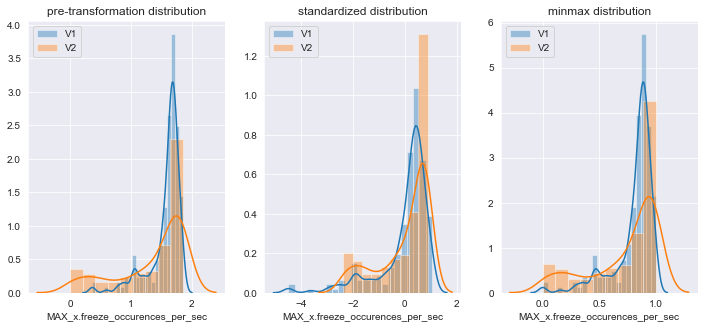

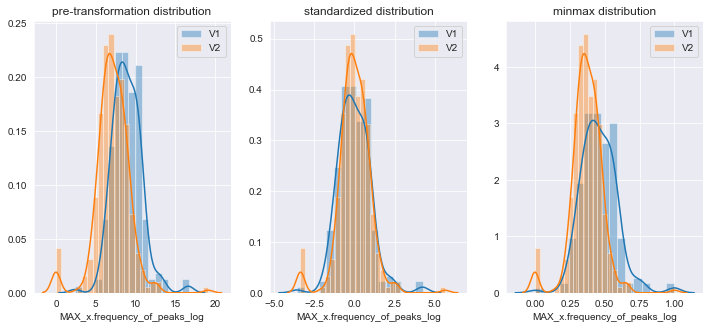

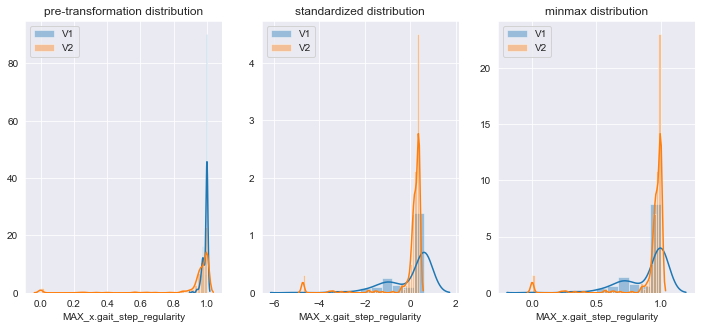

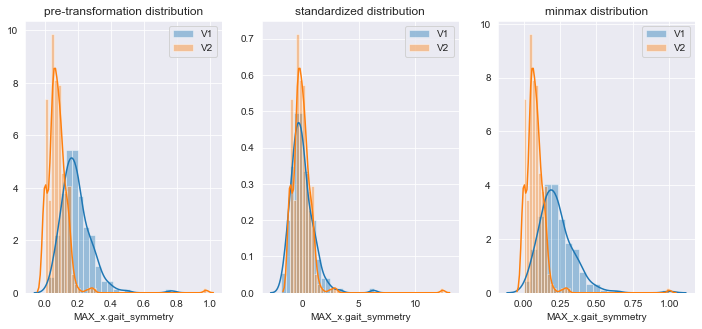

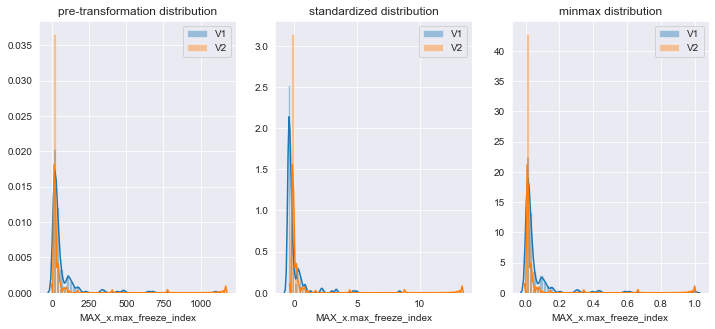

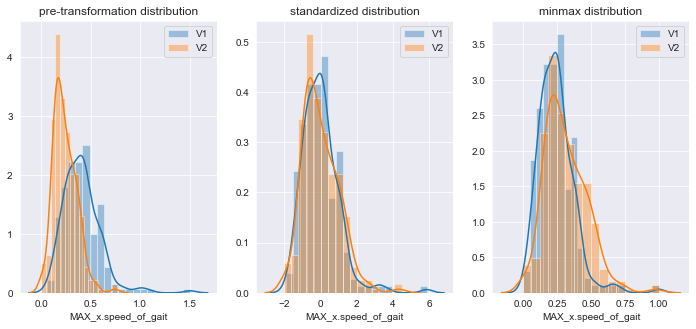

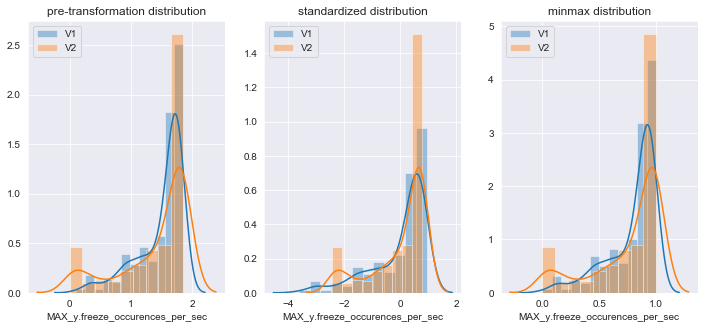

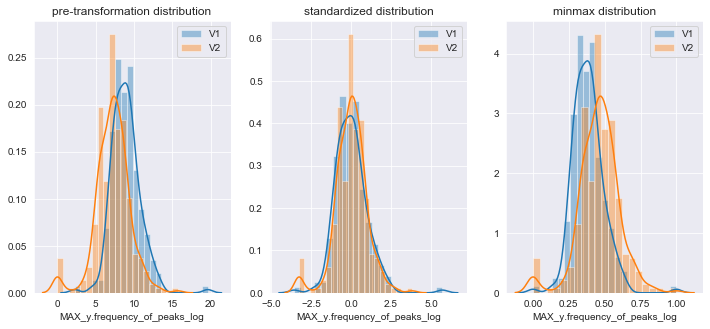

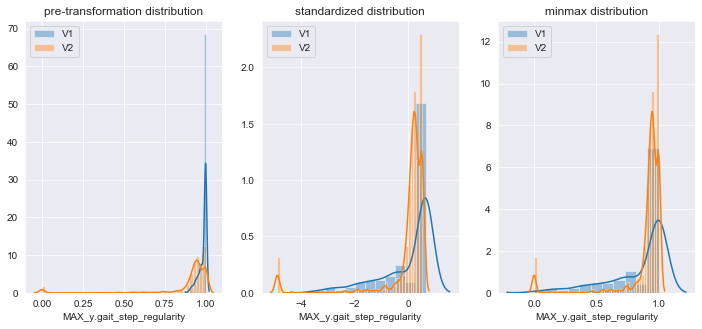

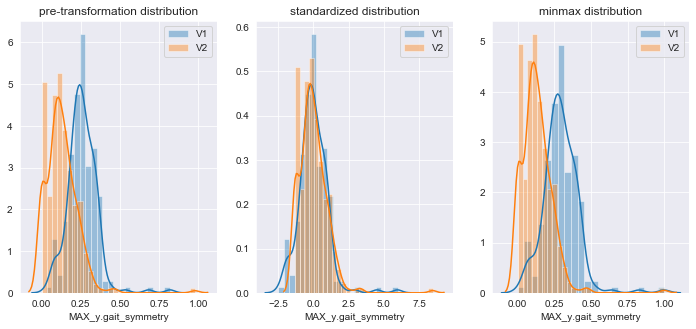

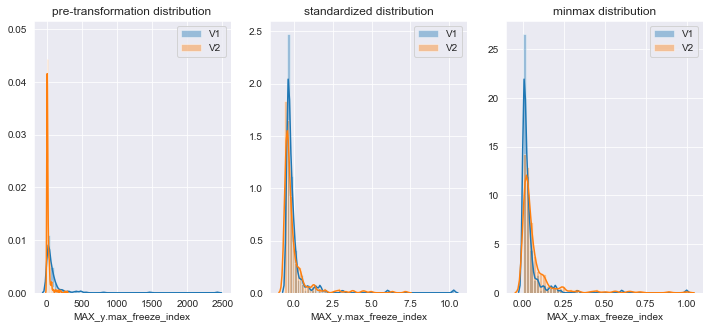

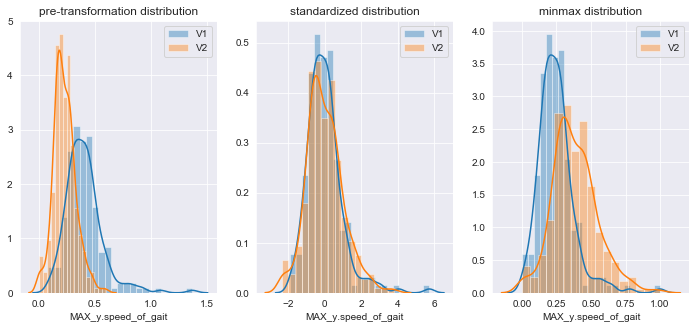

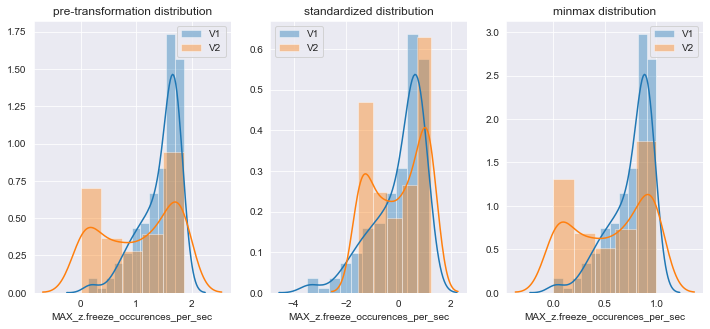

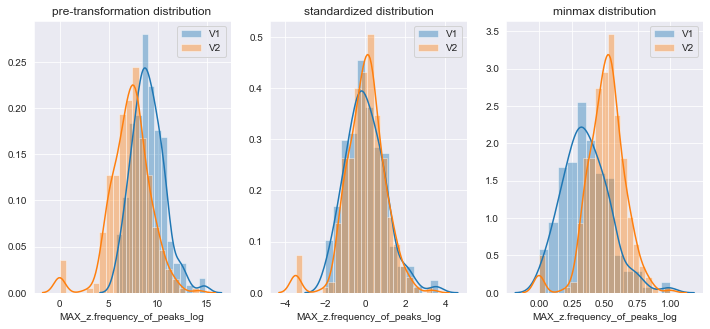

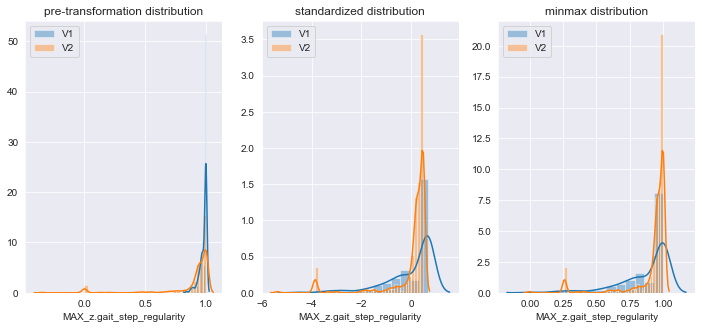

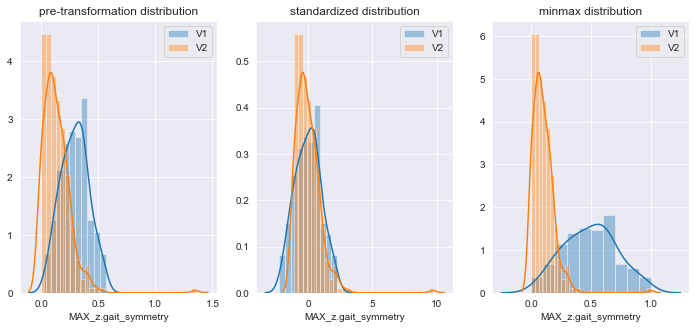

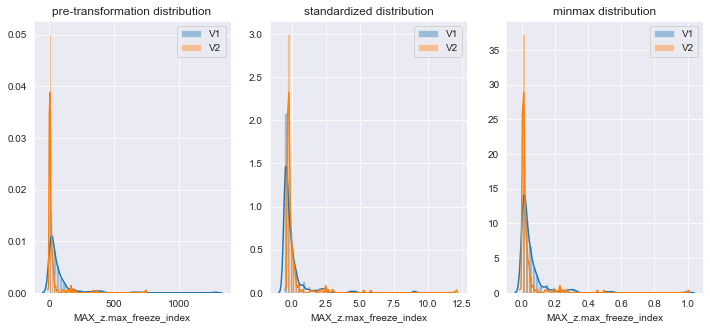

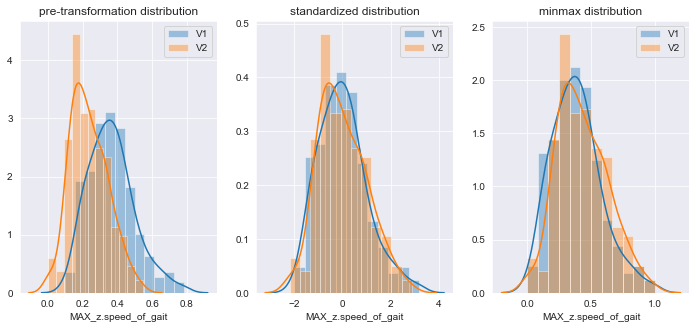

In [346]:
plot_distribution_scaling(data)

# Will normalizing by group helps reduce PCA separation??

In [340]:
data_V1 = data[data["version"] == "V1"].reset_index(drop = True)
data_V2 = data[data["version"] == "V2"].reset_index(drop = True)
    
## scaled to normal distribution ##
normal_scaled_data_V1 = pd.DataFrame(data = standard_scaler.fit_transform(
                                                data_V1[feature_cols].dropna()),
                                         columns = feature_cols)
normal_scaled_data_V1 = pd.concat([normal_scaled_data_V1, data_V1[["PD", "gender", "version"]]], axis = 1)
    
normal_scaled_data_V2 = pd.DataFrame(data = standard_scaler.fit_transform(
                                                data_V2[feature_cols].dropna()),
                                         columns = feature_cols)
normal_scaled_data_V2 = pd.concat([normal_scaled_data_V2, data_V2[["PD", "gender", "version"]]], axis = 1)

In [341]:
grouped_normalized = pd.concat([normal_scaled_data_V1, normal_scaled_data_V2]).reset_index(drop = True)

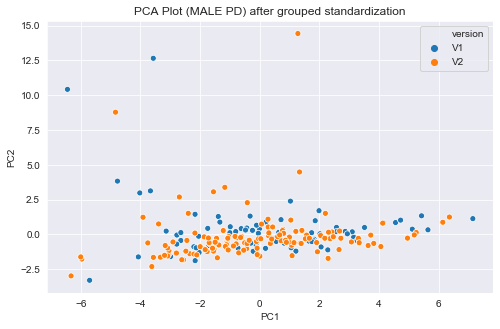

In [354]:
male_PD_data = grouped_normalized[(grouped_normalized["gender"] == "male") 
                               & (grouped_normalized["PD"] == 1)].reset_index(drop = True)
X = male_PD_data[[feat for feat in male_PD_data.columns if ("." in feat)]]
y = male_PD_data[["version", "PD"]]
X_scaled = X


#Plotting the Cumulative Summation of the Explained Variance
pca = PCA().fit(X_scaled)
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data = principal_comp)
principal_df = pd.concat([principal_df, y], axis = 1)

plt.figure(figsize=(8,5))
sns.scatterplot(principal_df[0], principal_df[1], 
                hue = principal_df["version"])
plt.title("PCA Plot (MALE PD) after grouped standardization")
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.grid()
plt.show()